<a href="https://colab.research.google.com/github/datle2403/datle2403/blob/main/Learning_Best_Practices_for_Model_Evaluation_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
df=pd.read_csv('data.csv',header=0)
df=df.iloc[:,:-1]
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [ ]:

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=1,test_size=0.2)

#Create pipeline

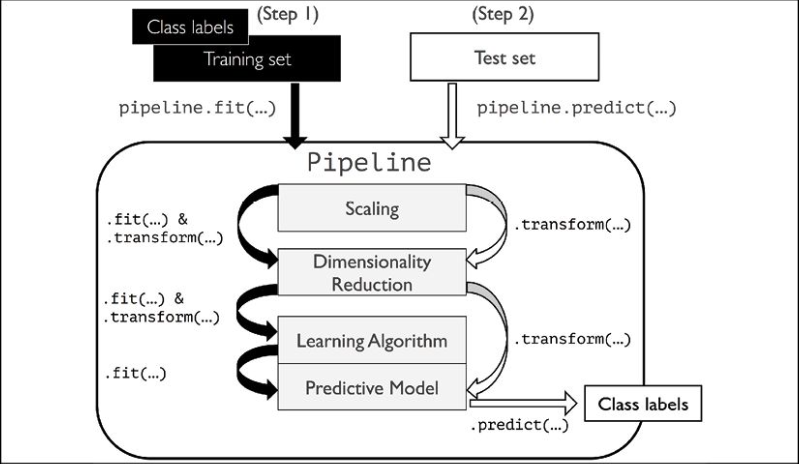

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
pipeline=make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state=1,solver='lbfgs'))
pipeline.fit(X_train,y_train)
pipeline.score(X_test,y_test)

0.956140350877193

# Using k-fold validation to assess model performace


**Holdout validation** and **k-fold validation** technique to obtain reliable estimate

Model selection: tuning and comparing different hyperameter setting. (optimal value for hyperameter)

If we reuse the same test data over and over again, it will become part of your train_set and the model is likely to overfit. (train on train_set, then predict with X_test, then tuning...)

Holdout method: plit dataset into 3 part: train, validation, test set. the performance in validation is use for model selection. This way can obtain less biased.

The draw_back of Holdout method: sensitive to how we partition the train to train and valid set.
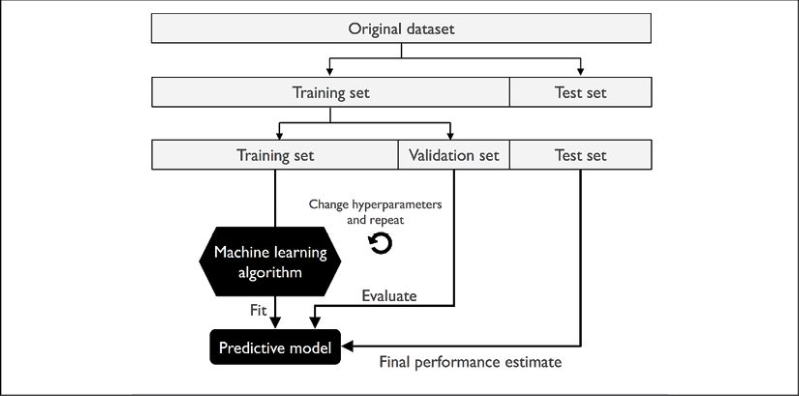



K-fold validation: split the training dataset into k folds without replacement, k-1 fold use for training, the last fold use for performance evaluation.

* Do this for k times

At the end, we obtain k model and their score on the last fold. we then averaged the score and then parameter tunning.
We then do last performance for test set.

Pro: the model only see data examples exactly one times.
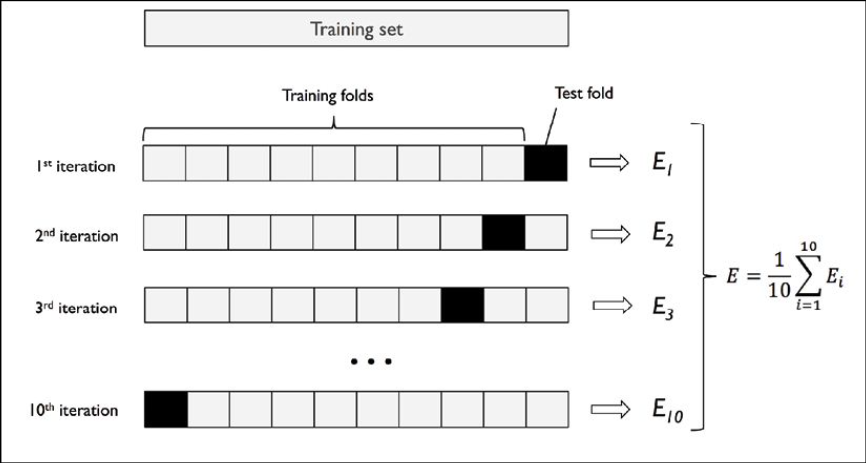

Standard k folds is 10. For smaller dataset, increase k folds make lower the bias, higher the variance since more data are use to train.

For large dataset, decrease k fold

Leave one out cross validation (LOOCV): we set k=n number of training example. the each fold contain 1 training example -> only use for very small dataset.



Another improvement of k-fold is stratify k fold. especially work for unequal proportion.


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold=StratifiedKFold(n_splits=10).split(X_train,y_train)
scores=[]
for k,(train,test) in enumerate(kfold):
  pipeline.fit(X_train[train],y_train[train])
  score=pipeline.score(X_train[test],y_train[test])
  scores.append(score)
  print(k+1,'fold, score:',score)
scores=np.array(scores)
m=scores.mean()
std=scores.std()
print(m,'+-',std)

1 fold, score: 0.9347826086956522
2 fold, score: 0.9347826086956522
3 fold, score: 0.9565217391304348
4 fold, score: 0.9565217391304348
5 fold, score: 0.9347826086956522
6 fold, score: 0.9555555555555556
7 fold, score: 0.9777777777777777
8 fold, score: 0.9333333333333333
9 fold, score: 0.9555555555555556
10 fold, score: 0.9555555555555556
0.9495169082125603 +- 0.013854294239660376


In [ ]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(estimator=pipeline, X=X_train, y=y_train,cv=10,n_jobs=1)
print(scores)
m=scores.mean()
std=scores.std()
print(m,'+-',std)

[0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
0.9495169082125603 +- 0.013854294239660376


# debugging alogrithm with learning and validation curves. 

learning curve and validation curves tell us wether model has underfitting or overfitting. 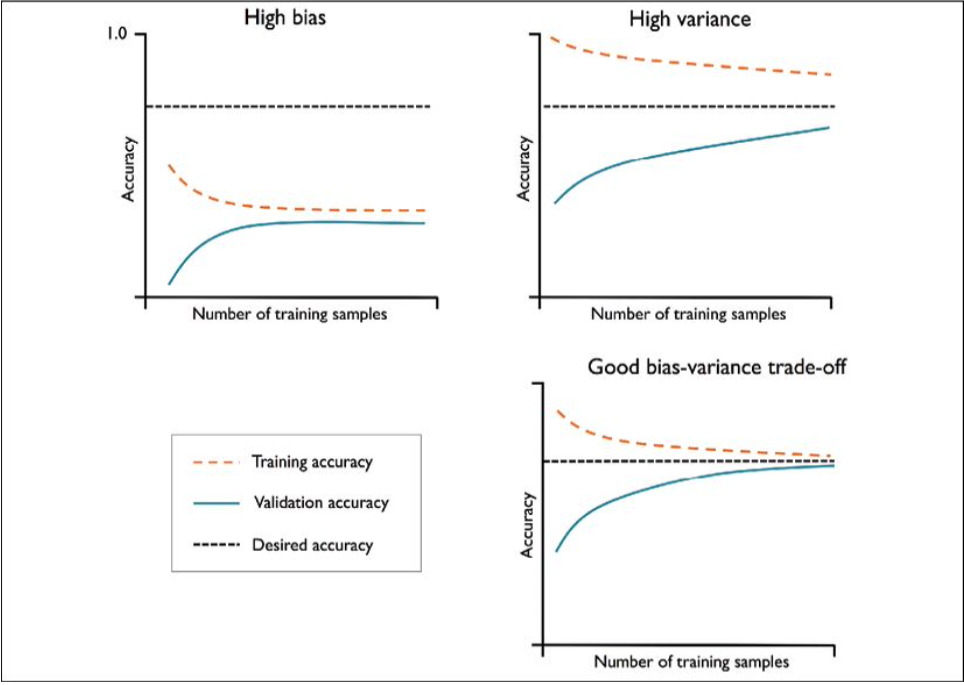

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
pipeline=make_pipeline(StandardScaler(),LogisticRegression(solver='lbfgs',random_state=1,penalty='l2',max_iter=10000))
train_sizes,train_scores,test_scores =learning_curve(estimator=pipeline,X=X_train,y=y_train,cv=10
                                                  ,n_jobs=1,train_sizes=np.linspace(0.1,1.0,10))

In [ ]:
test_scores

array([[0.84782609, 0.93478261, 0.93478261, 0.97826087, 0.91304348,
        0.95555556, 0.97777778, 0.93333333, 0.97777778, 1.        ],
       [0.95652174, 0.97826087, 0.93478261, 0.97826087, 0.93478261,
        0.95555556, 0.97777778, 0.91111111, 0.97777778, 0.93333333],
       [0.95652174, 0.97826087, 0.93478261, 0.97826087, 0.93478261,
        0.95555556, 1.        , 0.91111111, 0.97777778, 0.97777778],
       [0.95652174, 0.97826087, 0.95652174, 0.97826087, 0.95652174,
        0.95555556, 0.97777778, 1.        , 0.97777778, 0.97777778],
       [0.97826087, 0.97826087, 0.95652174, 0.95652174, 0.95652174,
        0.95555556, 0.97777778, 1.        , 0.97777778, 0.95555556],
       [0.95652174, 0.97826087, 0.97826087, 0.97826087, 0.95652174,
        0.95555556, 0.97777778, 0.97777778, 0.97777778, 0.97777778],
       [0.97826087, 0.97826087, 0.95652174, 0.97826087, 0.95652174,
        0.97777778, 0.97777778, 0.97777778, 0.97777778, 0.97777778],
       [1.        , 0.97826087, 1.       

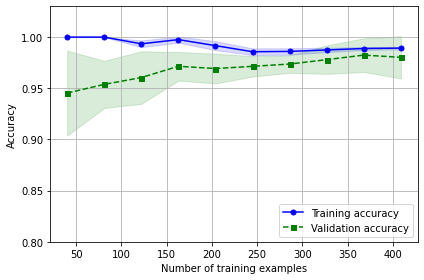

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()

From the plot, we can see that at 250 example. the model is overfitting, it needs more data.

In [ ]:
from sklearn.model_selection import validation_curve
param_range=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores,test_scores=validation_curve(X=X_train,y=y_train,estimator=pipeline,param_name='logisticregression__C',param_range=param_range,cv=10)

In [ ]:
train_scores

array([[0.89486553, 0.88508557, 0.88997555, 0.88753056, 0.89242054,
        0.88536585, 0.88536585, 0.89268293, 0.88780488, 0.8902439 ],
       [0.95110024, 0.94376528, 0.95354523, 0.94865526, 0.95599022,
        0.95121951, 0.94634146, 0.95365854, 0.94634146, 0.94878049],
       [0.98777506, 0.98533007, 0.98288509, 0.9804401 , 0.99022005,
        0.98780488, 0.98536585, 0.9804878 , 0.98536585, 0.98292683],
       [0.98777506, 0.98777506, 0.99022005, 0.99022005, 0.99022005,
        0.9902439 , 0.9902439 , 0.98780488, 0.9902439 , 0.98780488],
       [0.98533007, 0.98777506, 0.98533007, 0.99266504, 0.99266504,
        0.9902439 , 0.9902439 , 0.98780488, 0.9902439 , 0.98780488],
       [0.99022005, 0.99022005, 0.99022005, 0.99511002, 1.        ,
        0.9902439 , 0.9902439 , 0.99512195, 0.99268293, 0.98780488]])

In [ ]:
test_scores

array([[0.80434783, 0.95652174, 0.86956522, 0.91304348, 0.86956522,
        0.91111111, 0.97777778, 0.84444444, 0.86666667, 0.84444444],
       [0.93478261, 1.        , 0.91304348, 0.93478261, 0.91304348,
        0.95555556, 0.97777778, 0.88888889, 0.97777778, 0.93333333],
       [0.97826087, 1.        , 0.95652174, 0.95652174, 0.95652174,
        0.95555556, 0.97777778, 1.        , 1.        , 0.97777778],
       [1.        , 0.97826087, 1.        , 0.97826087, 0.93478261,
        0.95555556, 0.97777778, 0.97777778, 1.        , 1.        ],
       [0.95652174, 0.97826087, 1.        , 0.95652174, 0.93478261,
        0.95555556, 0.97777778, 0.95555556, 1.        , 1.        ],
       [0.95652174, 0.95652174, 0.97826087, 0.93478261, 0.93478261,
        0.97777778, 0.95555556, 0.93333333, 0.95555556, 0.97777778]])

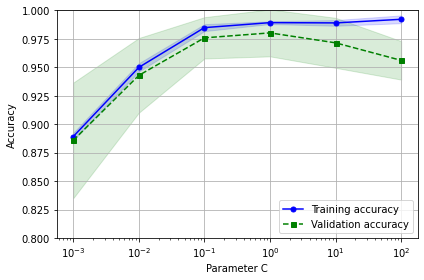

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()

# Fine-tunning machine learning model by grid_search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
pipeline=make_pipeline(StandardScaler(),SVC(random_state=1))
param_range=[0.0001,0.001,0.01,0.1,1,10,100,1000]
param_grid=[{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__kernel':['rbf'],'svc__gamma':param_range}]
gs=GridSearchCV(estimator=pipeline,param_grid=param_grid,scoring='accuracy',cv=10,refit=True,n_jobs=-1)
gs=gs.fit(X_train,y_train)

0.9846859903381642

In [ ]:
df1=pd.DataFrame(gs.cv_results_)

In [ ]:
best_score=gs.best_score_
best_model=gs.best_estimator_

In [ ]:
best_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100, gamma=0.001, random_state=1))])

In [ ]:
gs.best_params_

{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

In [ ]:
best_model.score(X_test,y_test)

0.9736842105263158

In [ ]:
gs.n_splits_

10

Nested cross_validation


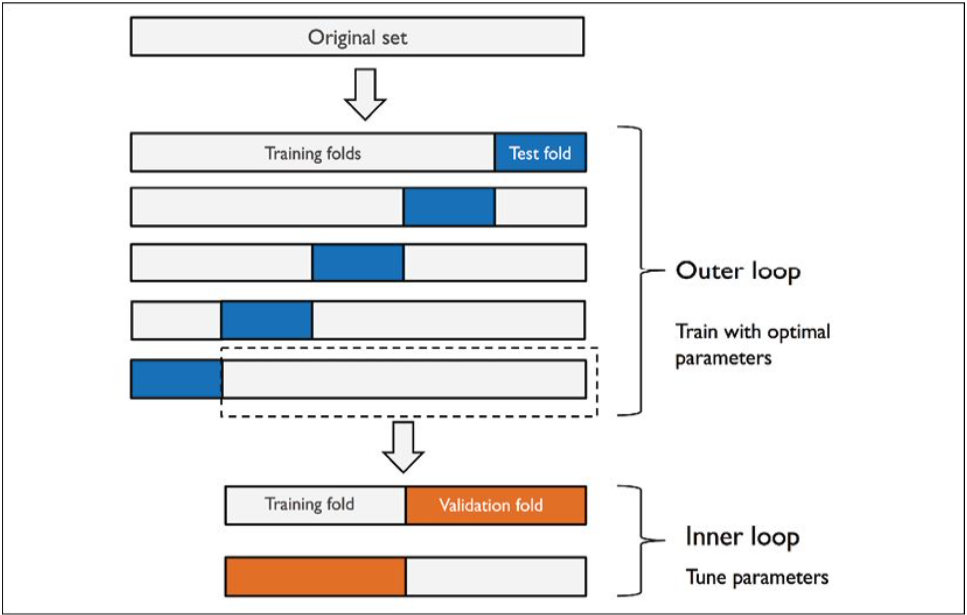

In this example, we have 5 k-fold group to split the dataset. This will result in dataset . then For each dataset, it will 2-fold, produce 2 sub-model for ech dataset, then sub_model is for predict the validation fold and produce score, average the score. The tuning is in inner loop, where for each dataset, there will be 8 * 1+ 8 * 8 * 1 model, the best model is use for predict the test fold. So there will be 72 * 5=360 models. 

In [ ]:
from sklearn.model_selection import cross_val_score
gs=GridSearchCV(estimator=pipeline,param_grid=param_grid,scoring='accuracy',cv=2)
scores= cross_val_score(gs,X=X_train,y=y_train,cv=5,scoring='accuracy')

In [ ]:
print(scores.mean(),'+-',scores.std())

0.9736263736263737 +- 0.014906219743132467


In [ ]:
from sklearn.tree import DecisionTreeClassifier
max_depth=[1,2,3,4,5,6,7]
param_grid=[{'decisiontreeclassifier__max_depth':max_depth}]

tree_pipeline=make_pipeline(DecisionTreeClassifier(random_state=0))
# see name by printing tree_pipeline
gs=GridSearchCV(estimator=tree_pipeline,param_grid=param_grid,scoring='accuracy',cv=2)
scores=cross_val_score(gs,X_train,y_train,cv=5,scoring='accuracy')

In [ ]:
print(scores.mean(),'+-',scores.std())

0.9340659340659341 +- 0.015540808377726326


#Confusion matrix(another metric beside 'accuracy')


reading confusion matrix: 
Is a square matrix that report counts of True positive, true negative, false pos, fals neg
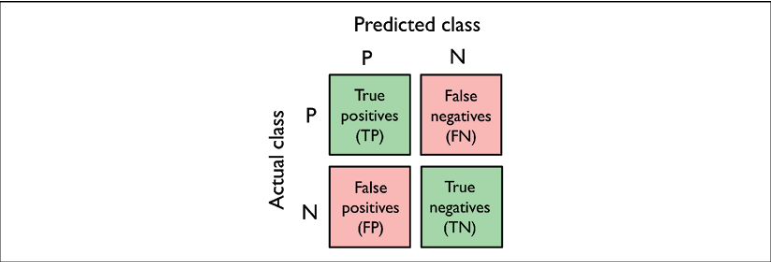

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(multi_class='ovr',solver='liblinear',random_state=1)
pipe=make_pipeline(StandardScaler(),PCA(n_components=2),lr)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
confs=confusion_matrix(y_true=y_test,y_pred=y_pred)

In [ ]:
confs

array([[71,  1],
       [ 4, 38]])

In [ ]:
y_pred1=best_model.predict(X_test)
confs=confusion_matrix(y_true=y_test,y_pred=y_pred1)
confs

array([[71,  1],
       [ 2, 40]])

In [ ]:
pipe1=make_pipeline(StandardScaler(),PCA(n_components=2))
X_train_std=pipe1.fit_transform(X_train,y_train)
lr.fit(X_train_std,y_train)
y_pred2=lr.predict(pipe1.transform(X_test))
confs=confusion_matrix(y_true=y_test,y_pred=y_pred2)
confs

array([[71,  1],
       [ 4, 38]])

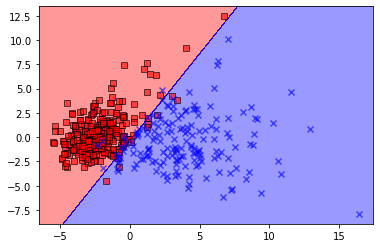

In [ ]:
from plot_decision_regions import plot_decision_regions
plot_decision_regions(X_train_std,y_train,classifier=lr)

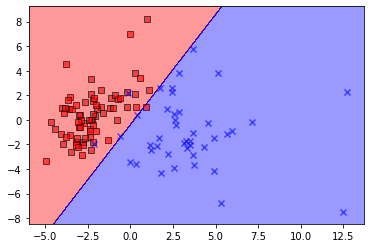

In [ ]:
from plot_decision_regions import plot_decision_regions
plot_decision_regions(pipe1.transform(X_test),y_test,classifier=lr)

In [ ]:
from plot_decision_regions import plot_decision_regions

In [ ]:
pipe2=make_pipeline(PCA(n_components=2),SVC(random_state=1))
pipe2.fit(X_train,y_train)

Pipeline(steps=[('pca', PCA(n_components=2)), ('svc', SVC(random_state=1))])

In [ ]:
plot_decision_regions(X_test,y_test,classifier=pipe2)

In [ ]:
y_p=pipe2.predict(X_test)
y_p

array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1])

In [ ]:
X_test.shape

(114, 30)

Optimizing the precision and recall of a classification model

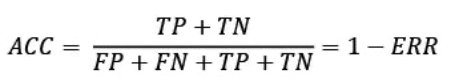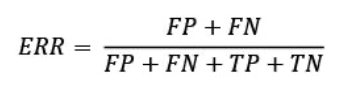

Error(ERR) and ACC(accuracy)
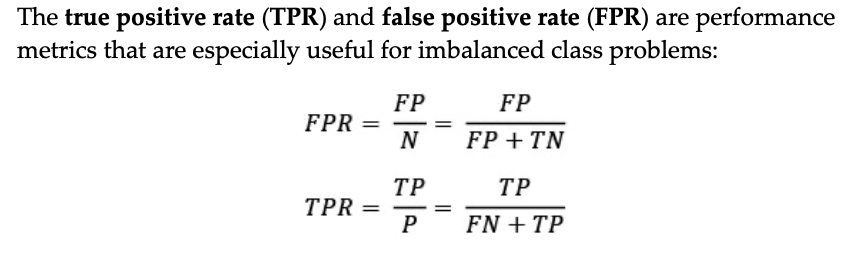

recall(REC) is synonymous with True positive rate(TPR):

**REC: from all True value, how many % does model predict correct**

**PRE: from all postive value, how many % does the positive value actually correct**

Optimize REC (make it highest) same to decrease False negative (person who actually got cancer but predict not).

Optimzie PRE same to decrease False positive (person who predict got cancer but actually not). this comes at the cost of missing malignant tumors more frequently (a high number of FN)

To balance the up- and down-sides of optimizing PRE and REC, often a combination of PRE and REC is used, the so-called F1 score:

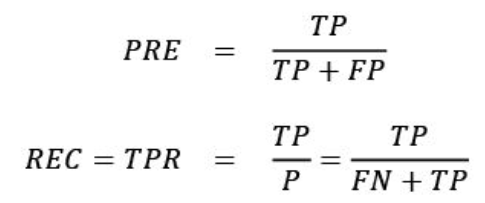

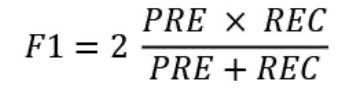

In [ ]:
from sklearn.metrics import f1_score,make_scorer
from sklearn.metrics import recall_score,precision_score,confusion_matrix

scorer=make_scorer(f1_score,pos_label=0)

pipeline=make_pipeline(StandardScaler(),SVC(random_state=1))
param_range=[0.0001,0.001,0.01,0.1,1,10,100,1000]
param_grid=[{'svc__C':param_range,'svc__kernel':['linear']},{'svc__C':param_range,'svc__kernel':['rbf'],'svc__gamma':param_range}]
gs=GridSearchCV(estimator=pipeline,param_grid=param_grid,scoring=scorer,cv=10,refit=True,n_jobs=-1)
gs=gs.fit(X_train,y_train)


In [ ]:
model=gs.best_estimator_
y_pred=model.predict(X_test)
conf=confusion_matrix(y_test,y_pred)
conf

array([[71,  1],
       [ 2, 40]])

In [ ]:
rec=recall_score(y_test,y_pred)
pre=precision_score(y_test,y_pred)
f1_score=f1_score(y_test,y_pred)

In [ ]:
print(rec,'/n',pre,'/n',f1_score)

0.9523809523809523 /n 0.975609756097561 /n 0.963855421686747


# Receiver operating characteristic(ROC)

Is a tool to select model for classification base on their performance w.r.t FPR and TPR(true positive rate). 

The diagonal of ROC graph can interpret as random guessing. all model the below diagonal is worst. The good model is above and have TPR=1 (100% accuracy) and FPR=0.

roc_auc: area under curve


In [104]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
pipe_lr=make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(penalty='l2',solver='lbfgs',random_state=1,C=100.0))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


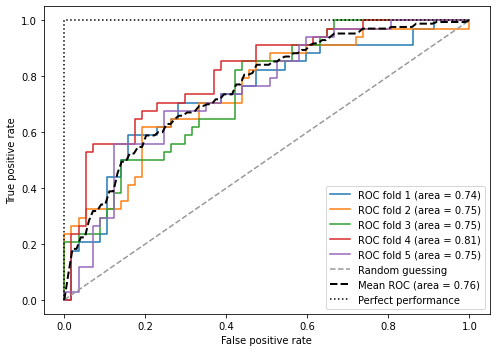

In [108]:
X_train2 = X_train[:, [4, 14]]
    
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

cv = list(StratifiedKFold(n_splits=5).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()

# dealing with class imbalance


In [110]:
X_imb=np.vstack((X[y==0],X[y==1][:40]))
y_imb=np.hstack((y[y==0],y[y==1][:40]))

When we fit with that imbalance dataset, it would make sense to focus on other metrics than accuracy metric

A way to solve this is upsampling the minority class



In [113]:
from sklearn.utils import resample

print('Number of class 1 examples before:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

Number of class 1 examples before: 40
Number of class 1 examples after: 357


In [114]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))